# Piyush Verma - 230968114


## Week 3

### Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

In [6]:
# Utility functions: plotting, showing images, printing model stats

def plot_history(hist, title_prefix=""):
    plt.figure(figsize=(12, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history.get('val_accuracy', []), label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(title_prefix + ' Accuracy'); plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history.get('val_loss', []), label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(title_prefix + ' Loss'); plt.legend()
    plt.show()


def show_one_from_each_class(X, y, class_names=None, cmap='gray'):
    classes = np.unique(y)
    n = len(classes)
    plt.figure(figsize=(15, 3))
    for i, cls in enumerate(classes):
        idx = np.where(y == cls)[0][0]
        plt.subplot(1, n, i+1)
        img = X[idx]
        if img.ndim == 3 and img.shape[2] == 1:
            plt.imshow(img.squeeze(), cmap=cmap)
        else:
            plt.imshow(img.astype('uint8'))
        title = class_names[cls] if class_names is not None else str(cls)
        plt.title(title)
        plt.axis('off')
    plt.show()

### Experiment Settings

In [7]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 128
EPOCHS = 10
PATIENCE = 4
USE_SAMPLE = False 

### Load Fashion-MNIST

Fashion-MNIST train shape: (60000, 28, 28) test shape: (10000, 28, 28)

Number of classes: 10
Image dimensions (H x W x C): (28, 28, 1)


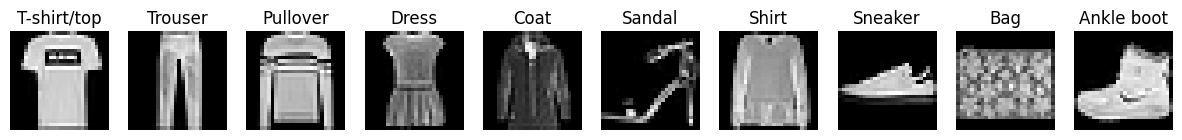

In [8]:
# Load Fashion-MNIST dataset
(fx_train, fy_train), (fx_test, fy_test) = keras.datasets.fashion_mnist.load_data()
print('Fashion-MNIST train shape:', fx_train.shape, 'test shape:', fx_test.shape)

fashion_class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Add channel dim for conv nets
fx_train_c = fx_train[..., np.newaxis]
fx_test_c = fx_test[..., np.newaxis]

# Show number of classes and image dimensions
print('\nNumber of classes:', len(np.unique(fy_train)))
print('Image dimensions (H x W x C):', fx_train_c.shape[1:])

# Display one image from each class
show_one_from_each_class(fx_train_c, fy_train, fashion_class_names)

### Normalization and train/validation split

In [9]:
# Normalize to [0,1]
fx_train_c = fx_train_c.astype('float32') / 255.0
fx_test_c = fx_test_c.astype('float32') / 255.0

# Create validation set
fx_train_c, fx_val_c, fy_train, fy_val = train_test_split(fx_train_c, fy_train, test_size=0.1, random_state=SEED)
print('After split — train:', fx_train_c.shape, 'val:', fx_val_c.shape)

# Optionally use smaller sample for quick runs
if USE_SAMPLE:
    sample_n = 5000
    fx_train_c = fx_train_c[:sample_n]
    fy_train = fy_train[:sample_n]

# One-hot for FCNN output
fy_train_cat = to_categorical(fy_train, 10)
fy_val_cat = to_categorical(fy_val, 10)
fy_test_cat = to_categorical(fy_test, 10)

After split — train: (54000, 28, 28, 1) val: (6000, 28, 28, 1)


In [10]:
input_shape_flat = (28*28,)

def build_fcnn_fashion(hidden_units=[512, 256], dropout=0.4):
    model = Sequential([
        layers.Input(shape=input_shape_flat),
        layers.Dense(hidden_units[0], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(hidden_units[1], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout/2),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

fcnn_model = build_fcnn_fashion()
fcnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,890 (2.06 MB)

 Trainable params: 537,354 (2.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

### Train FCNN (Fashion)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7599 - loss: 0.6892 - val_accuracy: 0.8407 - val_loss: 0.4325
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8409 - loss: 0.4347 - val_accuracy: 0.8620 - val_loss: 0.3843
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8516 - loss: 0.4051 - val_accuracy: 0.8537 - val_loss: 0.3910
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8621 - loss: 0.3774 - val_accuracy: 0.8708 - val_loss: 0.3541
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8653 - loss: 0.3671 - val_accuracy: 0.8690 - val_loss: 0.3624
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8700 - loss: 0.3518 - val_accuracy: 0.8690 - val_loss: 0.3610
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8726 - loss: 0.3459 - val_accuracy: 0.8750 - val_loss: 0.3499
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8749 - loss: 0.3379 - val_accuracy: 0.

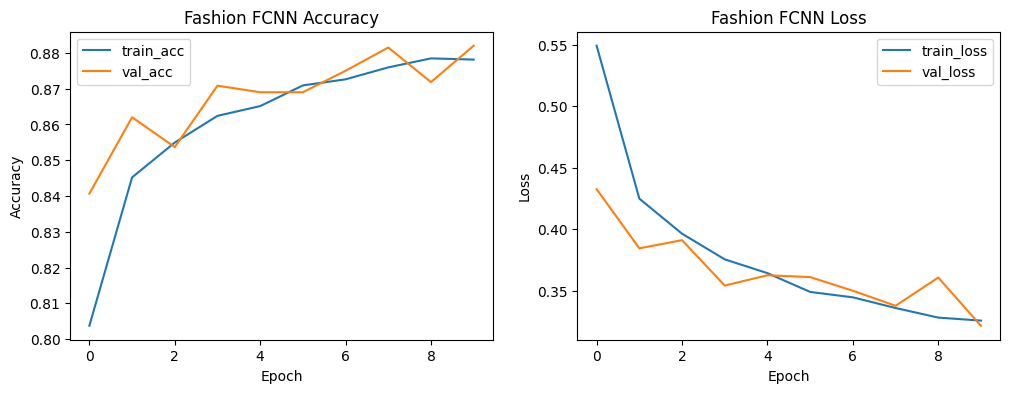

Fashion FCNN Test loss, acc: [0.34344562888145447, 0.8761000037193298]


In [11]:
fcnn_hist = fcnn_model.fit(fx_train_c.reshape((-1, 28*28)), fy_train_cat,
                           validation_data=(fx_val_c.reshape((-1, 28*28)), fy_val_cat),
                           epochs=EPOCHS, batch_size=BATCH_SIZE,
                           callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

plot_history(fcnn_hist, 'Fashion FCNN')

# Evaluate on test set
fcnn_eval = fcnn_model.evaluate(fx_test_c.reshape((-1, 28*28)), fy_test_cat, verbose=0)
print('Fashion FCNN Test loss, acc:', fcnn_eval)

### CNN experiments for Fashion-MNIST

In [12]:
# Build CNN-1 and CNN-2 as specified:
# - CNN-1: One conv (32 kernels 5x5 stride 1, padding=0), ReLU, MaxPool stride=2, Flatten, Dense(100), Softmax
# - CNN-2: Two conv back-to-back (32 kernels 3x3), ReLU after each, MaxPool, Flatten, Dense(100), Softmax

def build_cnn1_fashion():
    model = Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(5,5), strides=1, padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def build_cnn2_fashion():
    model = Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn1_fashion = build_cnn1_fashion()
cnn2_fashion = build_cnn2_fashion()

print('CNN-1 summary:')
cnn1_fashion.summary()
print('\nCNN-2 summary:')
cnn2_fashion.summary()

CNN-1 summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │       460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,742 (1.77 MB)

 Trainable params: 462,742 (1.77 MB)

 Non-trainable params: 0 (0.00 B)


CNN-2 summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │       460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,478 (1.80 MB)

 Trainable params: 471,478 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

### Train CNN-1 and CNN-2 (Fashion)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7499 - loss: 0.7146 - val_accuracy: 0.8755 - val_loss: 0.3613
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8754 - loss: 0.3553 - val_accuracy: 0.8843 - val_loss: 0.3263
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8939 - loss: 0.3025 - val_accuracy: 0.8887 - val_loss: 0.3074
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9043 - loss: 0.2688 - val_accuracy: 0.8978 - val_loss: 0.2887
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9137 - loss: 0.2428 - val_accuracy: 0.8960 - val_loss: 0.2928
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9196 - loss: 0.2222 - val_accuracy: 0.8957 - val_loss: 0.2933
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9269 - loss: 0.2043 - val_accuracy: 0.8965 - val_loss: 0.2937
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9334 - loss: 0.1883 - val_accurac

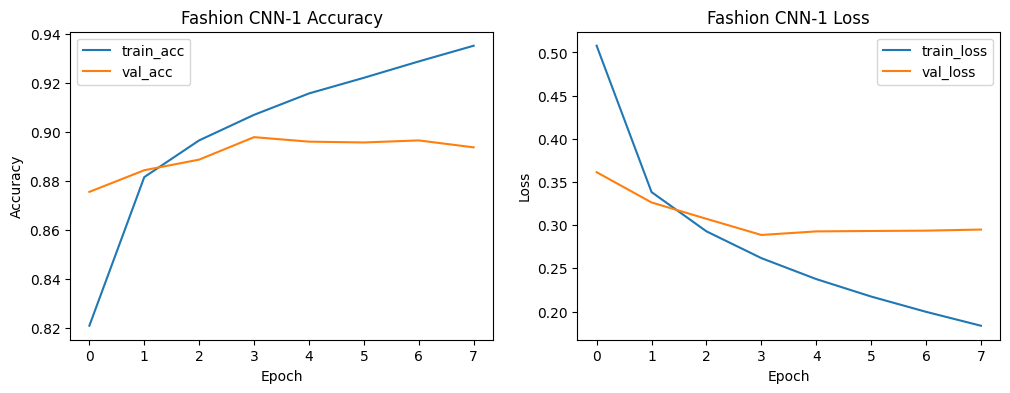

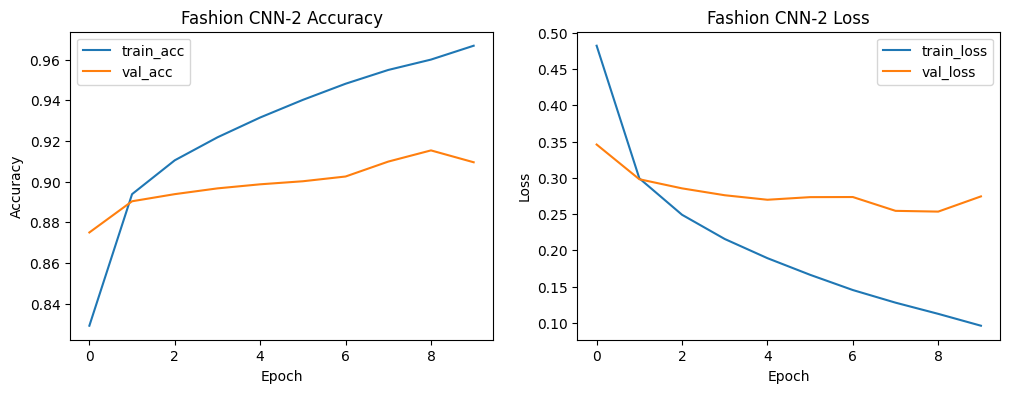

Fashion CNN-1 Test loss, acc: [0.30670440196990967, 0.8903999924659729]
Fashion CNN-2 Test loss, acc: [0.27712005376815796, 0.9114999771118164]


In [14]:
cnn1_hist = cnn1_fashion.fit(fx_train_c, to_categorical(fy_train), validation_data=(fx_val_c, to_categorical(fy_val)),
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

cnn2_hist = cnn2_fashion.fit(fx_train_c, to_categorical(fy_train), validation_data=(fx_val_c, to_categorical(fy_val)),
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

plot_history(cnn1_hist, 'Fashion CNN-1')
plot_history(cnn2_hist, 'Fashion CNN-2')

# Evaluate on test set
cnn1_eval = cnn1_fashion.evaluate(fx_test_c, to_categorical(fy_test), verbose=0)
cnn2_eval = cnn2_fashion.evaluate(fx_test_c, to_categorical(fy_test), verbose=0)
print('Fashion CNN-1 Test loss, acc:', cnn1_eval)
print('Fashion CNN-2 Test loss, acc:', cnn2_eval)

### Compare FCNN vs CNNs (Fashion)

In [ ]:
print('FCNN params:', fcnn_model.count_params())
print('CNN-1 params:', cnn1_fashion.count_params())
print('CNN-2 params:', cnn2_fashion.count_params())

FCNN params: 538890
CNN-1 params: 462742
CNN-2 params: 471478

Inferences for Fashion-MNIST:
- Which performs better (accuracy): compare test accuracies above.
- CNNs typically outperform FCNN for images because of spatial inductive bias and fewer params for similar accuracy.


Inferences for Fashion-MNIST:

CNNs typically outperform FCNN for images because of spatial inductive bias and fewer params for similar accuracy.

### Load CIFAR-10

CIFAR-10 train shape: (50000, 32, 32, 3) test shape: (10000, 32, 32, 3)

Number of classes: 10
Image dimensions (H x W x C): (32, 32, 3)


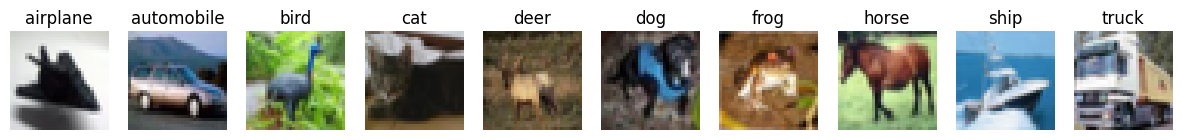

After split — train: (45000, 32, 32, 3) val: (5000, 32, 32, 3)


In [15]:
(cx_train, cy_train), (cx_test, cy_test) = keras.datasets.cifar10.load_data()
cy_train = cy_train.ravel()
cy_test = cy_test.ravel()
print('CIFAR-10 train shape:', cx_train.shape, 'test shape:', cx_test.shape)

cifar_class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Show number of classes and image dims
print('\nNumber of classes:', len(np.unique(cy_train)))
print('Image dimensions (H x W x C):', cx_train.shape[1:])

# Display one image from each class
show_one_from_each_class(cx_train, cy_train, cifar_class_names, cmap=None)

cx_train = cx_train.astype('float32') / 255.0
cx_test = cx_test.astype('float32') / 255.0

cx_train, cx_val, cy_train, cy_val = train_test_split(cx_train, cy_train, test_size=0.1, random_state=SEED)
print('After split — train:', cx_train.shape, 'val:', cx_val.shape)

if USE_SAMPLE:
    cx_train = cx_train[:5000]
    cy_train = cy_train[:5000]

cy_train_cat = to_categorical(cy_train, 10)
cy_val_cat = to_categorical(cy_val, 10)
cy_test_cat = to_categorical(cy_test, 10)

### FCNN for CIFAR-10

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,682,826 (14.05 MB)

 Trainable params: 3,679,754 (14.04 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2861 - loss: 2.1982 - val_accuracy: 0.3478 - val_loss: 1.8479
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3804 - loss: 1.7713 - val_accuracy: 0.3286 - val_loss: 1.9186
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4026 - loss: 1.6844 - val_accuracy: 0.3844 - val_loss: 1.7590
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4086 - loss: 1.6516 - val_accuracy: 0.3616 - val_loss: 1.7976
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4137 - loss: 1.6379 - val_accuracy: 0.4010 - val_loss: 1.6579
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4236 - loss: 1.6261 - val_accuracy: 0.4184 - val_loss: 1.6305
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4323 - loss: 1.5933 - val_accuracy: 0.4436 - val_loss: 1.5608
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4319 - loss: 1.5894 - val_accu

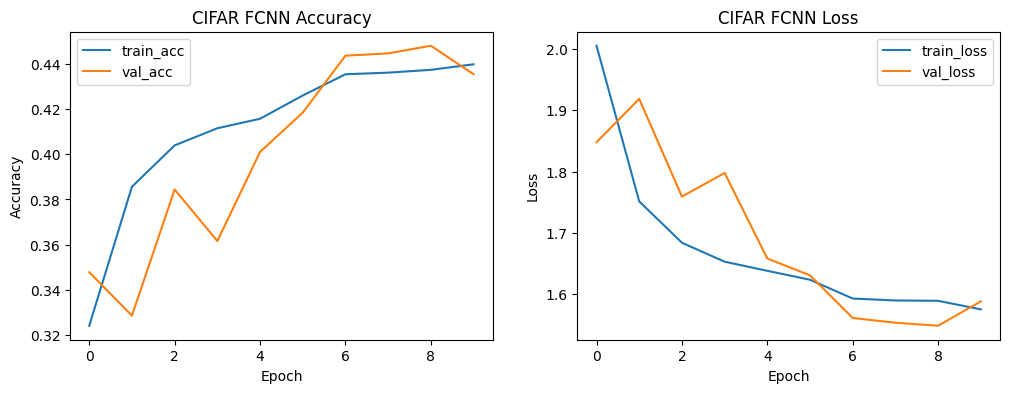

CIFAR FCNN Test loss, acc: [1.51752507686615, 0.45910000801086426]


In [16]:
# Flatten 32x32x3 input and build an FCNN similar to the Fashion one (but wider) — note: FCNNs perform poorly on natural images.

input_shape_cifar_flat = (32*32*3,)

def build_fcnn_cifar(hidden_units=[1024, 512], dropout=0.5):
    model = Sequential([
        layers.Input(shape=input_shape_cifar_flat),
        layers.Dense(hidden_units[0], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(hidden_units[1], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout/2),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

fcnn_cifar = build_fcnn_cifar()
fcnn_cifar.summary()

fcnn_cifar_hist = fcnn_cifar.fit(cx_train.reshape((-1, 32*32*3)), cy_train_cat,
                                 validation_data=(cx_val.reshape((-1, 32*32*3)), cy_val_cat),
                                 epochs=EPOCHS, batch_size=BATCH_SIZE,
                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

plot_history(fcnn_cifar_hist, 'CIFAR FCNN')

fcnn_cifar_eval = fcnn_cifar.evaluate(cx_test.reshape((-1, 32*32*3)), cy_test_cat, verbose=0)
print('CIFAR FCNN Test loss, acc:', fcnn_cifar_eval)

### CNN-1 and CNN-2 for CIFAR-10

CNN-1 (CIFAR) summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,742 (2.41 MB)

 Trainable params: 630,742 (2.41 MB)

 Non-trainable params: 0 (0.00 B)


CNN-2 (CIFAR) summary:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 638,454 (2.44 MB)

 Trainable params: 638,454 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3339 - loss: 1.8308 - val_accuracy: 0.5190 - val_loss: 1.3738
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5234 - loss: 1.3366 - val_accuracy: 0.5560 - val_loss: 1.2491
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5738 - loss: 1.2084 - val_accuracy: 0.5750 - val_loss: 1.1980
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6059 - loss: 1.1209 - val_accuracy: 0.5886 - val_loss: 1.1614
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6316 - loss: 1.0539 - val_accuracy: 0.6002 - val_loss: 1.1363
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6554 - loss: 0.9927 - val_accuracy: 0.6074 - val_loss: 1.1231
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6743 - loss: 0.9420 - val_accuracy: 0.6182 - val_loss: 1.1012
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6864 - loss: 0.9017 - val_accu

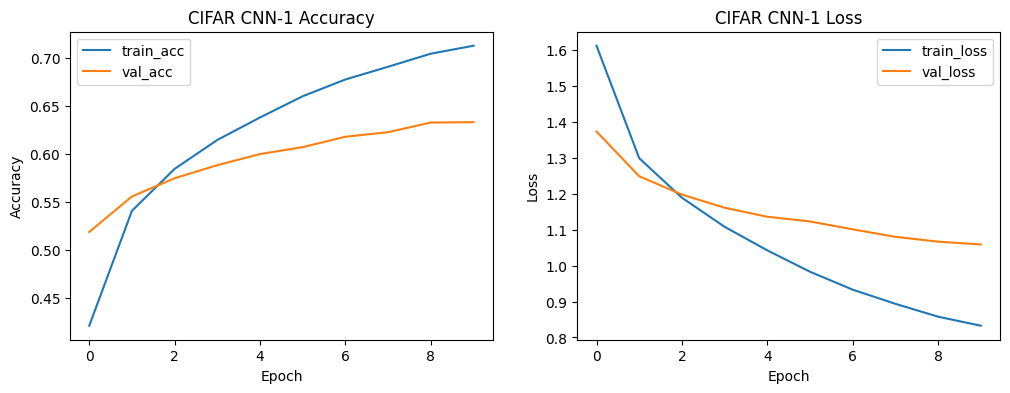

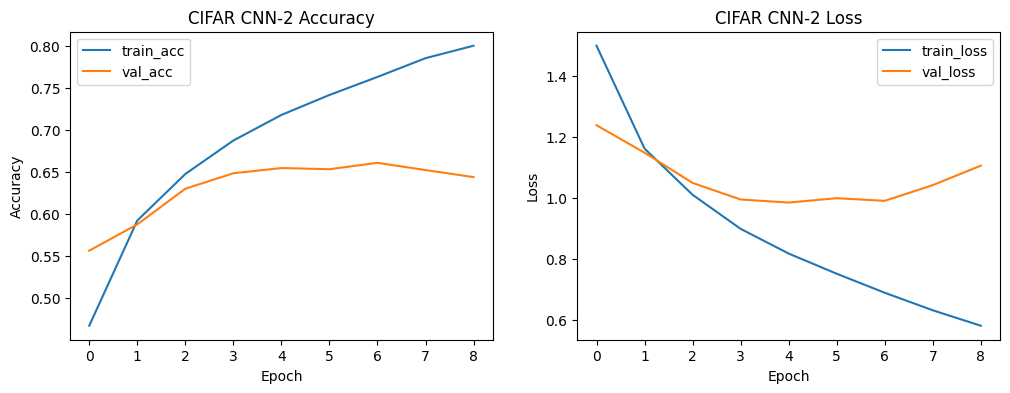

CIFAR CNN-1 Test loss, acc: [1.06227445602417, 0.6419000029563904]
CIFAR CNN-2 Test loss, acc: [0.9860553741455078, 0.6650999784469604]


In [17]:
def build_cnn1_cifar():
    model = Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(32, kernel_size=(5,5), strides=1, padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def build_cnn2_cifar():
    model = Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn1_cifar = build_cnn1_cifar()
cnn2_cifar = build_cnn2_cifar()
print('CNN-1 (CIFAR) summary:')
cnn1_cifar.summary()
print('\nCNN-2 (CIFAR) summary:')
cnn2_cifar.summary()

cnn1_cifar_hist = cnn1_cifar.fit(cx_train, cy_train_cat, validation_data=(cx_val, cy_val_cat),
                                 epochs=EPOCHS, batch_size=BATCH_SIZE,
                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

cnn2_cifar_hist = cnn2_cifar.fit(cx_train, cy_train_cat, validation_data=(cx_val, cy_val_cat),
                                 epochs=EPOCHS, batch_size=BATCH_SIZE,
                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

plot_history(cnn1_cifar_hist, 'CIFAR CNN-1')
plot_history(cnn2_cifar_hist, 'CIFAR CNN-2')

cnn1_cifar_eval = cnn1_cifar.evaluate(cx_test, cy_test_cat, verbose=0)
cnn2_cifar_eval = cnn2_cifar.evaluate(cx_test, cy_test_cat, verbose=0)
print('CIFAR CNN-1 Test loss, acc:', cnn1_cifar_eval)
print('CIFAR CNN-2 Test loss, acc:', cnn2_cifar_eval)

### Compare FCNN vs CNNs (CIFAR)

In [18]:
print('\nCIFAR — parameter counts:')
print('FCNN:', fcnn_cifar.count_params())
print('CNN-1:', cnn1_cifar.count_params())
print('CNN-2:', cnn2_cifar.count_params())


CIFAR — parameter counts:
FCNN: 3682826
CNN-1: 630742
CNN-2: 638454


Inferences for CIFAR:

CNNs typically outperform FCNN for images because of spatial inductive bias and fewer params for similar accuracy.